# Exercise 12
## Satyabrata Pahari s1282006

## Import Required Libraries

We start by importing all the required libraries. These include psycopg2 for database operations, pandas for data manipulation, PAMI for pattern mining, and plotly for data visualization.

In [85]:
import psycopg2
import pandas as pd
import numpy as np
from PAMI.extras.DF2DB import denseDF2DB as pro
from PAMI.frequentPattern.basic import FPGrowth as alg
from PAMI.extras.graph import dataFrameInToFigures as dif
from config import config
import plotly.express as px
import geopandas as gpd
from shapely import wkt


## Define DBManager Class

DBManager is a class for managing connections to a PostgreSQL database. This class helps in connecting to and disconnecting from the PostgreSQL database.


In [86]:
class DBManager:
    def __init__(self, params):
        self.conn = None
        self.cursor = None
        self.params = params

    def connect(self):
        print('Connecting to the PostgreSQL database...')
        self.conn = psycopg2.connect(**self.params)
        self.cursor = self.conn.cursor()

    def close(self):
        if self.cursor:
            self.cursor.close()
        if self.conn:
            self.conn.close()
        print('Database connection closed.')

    def fetch_coordinates(self, station_ids):
        self.cursor.execute(
            "SELECT stationID, ST_X(Location::geometry), ST_Y(Location::geometry) FROM stationInfo WHERE stationID IN %s",
            (tuple(station_ids),)
        )
        rows = self.cursor.fetchall()
        coordinates = {row[0]: (row[1], row[2]) for row in rows}
        return coordinates


## Define DataProcessor Class

DataProcessor is a class for processing data. This class includes methods for preprocessing the data, converting it into a transactional database, running the FP-growth algorithm on the data, and plotting the patterns on an interactive map.


In [87]:
class DataProcessor:
    @staticmethod
    def process_data(filename):
        df = pd.read_csv(filename, index_col=0)
        df.fillna(0, inplace=True)
        df[df >= 100] = 0
        df.index.names = ['tid']
        df.reset_index(drop=True, inplace=True)
        df.index += 1
        db = pro.denseDF2DB(inputDF=df, thresholdValue=15, condition='>=')
        db.createTransactional(outputFile='transactionalDB.txt')
        print('The output file is saved at ' + db.getFileName())
        df.to_csv('PM24HeavyPollutionRecordingSensors.csv', index=True)

    @staticmethod
    def run_fpgrowth(inputFile, minSupList):
        result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
        algorithm = 'FP-growth'
        for minSup in minSupList:
            obj = alg.FPGrowth(inputFile, minSup, '\t')
            obj.startMine()
            filename = 'frequentPatterns.txt'
            obj.save(filename)
            result.loc[result.shape[0]] = [algorithm, minSup, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]
        return result


## Define Helper Functions

These functions help in reading and processing patterns from a file, and plotting these patterns on an interactive map.


In [88]:
def read_and_process_patterns_file(file_path):
    with open(file_path, 'r') as file:
        data = file.read().split("\n")
    patterns = {}
    for line in data:
        if line:
            point, freq = line.split(":")
            point = point.strip()[6:-1]
            patterns[point] = int(freq)
    return patterns

def plot_patterns_on_map(patterns, coordinates):
    fig = px.scatter_mapbox(
        data_frame=pd.DataFrame(
            {
                'station': [station for station in patterns.keys() if station in coordinates],
                'lat': [coordinates[station][1] for station in patterns.keys() if station in coordinates],
                'lon': [coordinates[station][0] for station in patterns.keys() if station in coordinates],
                'size': [patterns[station] for station in patterns.keys() if station in coordinates]
            }
        ),
        lat='lat',
        lon='lon',
        color='size',
        size='size',
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=20,
        zoom=4,
        center=dict(lat=36.686567, lon=135.52000),
        mapbox_style="open-street-map"
    )
    fig.show()

In [91]:
filename = 'air_pollution_data.csv'
DataProcessor.process_data(filename)
minSupList = [223]
result = DataProcessor.run_fpgrowth('transactionalDB.txt', minSupList)
print(result)
ab = dif.dataFrameInToFigures(result)

The output file is saved at transactionalDB.txt
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
   algorithm  minSup  patterns   runtime     memory
0  FP-growth     223       158  0.564509  399396864


Connecting to the PostgreSQL database...


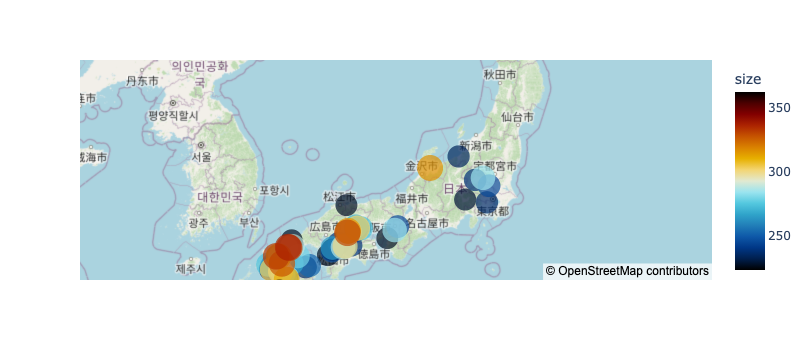

Database connection closed.


In [90]:
params = config()
db_manager = DBManager(params)
db_manager.connect()

patterns = read_and_process_patterns_file('frequentPatterns.txt')

coordinates = db_manager.fetch_coordinates(patterns.keys())

plot_patterns_on_map(patterns, coordinates)

db_manager.close()

https://github.com/satyappp/PAMI